# Observations of Cores and Filaments

We have derived sizes and shapes of cores and filaments.  What do they look like, in observations, in theory?

We start with the adopted centrally-flattened density profile:

\begin{equation}
    \rho(r) = \rho_c \frac{(c \cdot r_0)^\alpha}{(c \cdot r_0)^\alpha + r^\alpha}
\end{equation}


We'll start with $\alpha=2.33$ and $c=2.24$ (see homework).

For local clouds, we'll adopt a temperature $T=10$ K and a pressure $P/k = 10^5$ K cm$^{-3}$

We'll obtain $\rho_c$ and $r_0$ from the Bonnor-Ebert solution:

In [206]:
from astropy import units as u, constants

In [207]:
T = 10*u.K
mu = 2.3*u.Da
P_over_K = 3e5*u.K * u.cm**-3

c_s = np.sqrt(constants.k_B * T / mu).to(u.km/u.s)
M_BE = (1.18 * c_s**4 /
        (constants.G**(3./2.)) / (P_over_K * constants.k_B)**0.5).to(u.M_sun)
print(f"M_BE = {M_BE}")
rho_S = (1.18**2*c_s**6 / M_BE**2 / constants.G**3).to(u.g/u.cm**3)
rho_c = rho_S * 13.77
volume_density = (rho_c/(2.8*u.Da)).to(u.cm**-3)
print(f"Central & min density: {rho_c:0.2g}, {rho_S:0.2g}  (n_c = rho_c/mu_h2 = {volume_density:0.2g})")
r0 = (c_s / (4 * np.pi * constants.G * rho_c)**0.5).to(u.au)
print(f"r0 = {r0.to(u.au):0.1f}")

M_BE = 0.6988402994742438 solMass
Central & min density: 1.6e-18 g / cm3, 1.1e-19 g / cm3  (n_c = rho_c/mu_h2 = 3.4e+05 1 / cm3)
r0 = 1104.9 AU


Assuming the core remains optically thin and isothermal, we need only to determine its column density to determine its observable properties.

Column density $\Sigma = \int \rho dr$ - it is simply the sum of the density along the line of sight.

$$
\Sigma = \rho_c c r_0^\alpha \int_{-\infty}^\infty \frac{1}{(c r_0)^\alpha +r^\alpha} dr
$$

It's easiest to evaluate this numerically.

In [208]:
import numpy as np

In [209]:
# make a 3d grid:
sz = 100 # set the resolution: but not too big!
zz,yy,xx = grid = np.indices([sz,sz,sz])

In [246]:
# calculate radius from center
# set r_max = twice 6.4 r_0 (the 'core' is not defined outside this radius)
# 6.4 is the value of xi at maximum dimensionless mass
rmax = 2 * 6.4 * r0
rr_3d = ((zz-sz/2.)**2 + (yy-sz/2.)**2 + (xx-sz/2.)**2)
rr_3d = rr_3d / rr_3d.max() * rmax
# we do a 2d version too, for display purposes
rr_2d = ((yy-sz/2.)**2 + (xx-sz/2.)**2)
rr_2d = rr_2d / rr_2d.max() * rmax

In [247]:
# calculate density
def density_func(rr, const=2.24, alpha=2.33):
    return rho_c * (const * r0/u.au)**alpha  / ((const * r0/u.au)**alpha + (rr/u.au)**alpha)
density = density_func(rr_3d)

In [248]:
# just to verify, we can take the mean density over the whole volume and multiply
# by the volume to get the mass
mass_in_box = (density[rr_3d<rmax].mean() * (4/3*np.pi*rmax**3)).to(u.M_sun)
print(f"Mean density={density.mean()}")
print(f"Mass in box {mass_in_box} should be M_BE={M_BE}  (ratio={mass_in_box/M_BE})")

Mean density=4.66652730781921e-19 g / cm3
Mass in box 9.308823126064144 solMass should be M_BE=0.6988402994742438 solMass  (ratio=13.320386836688469)


There is a factor of ~3-4 discrepancy here that I have not resolved.  Please look for this in the homework and help me.

In [249]:
# integrate along the line-of-sight
# (this is spherically symmetric so we can use any axis)
dz = 2 * r0 / sz
column = (density * dz).sum(axis=0).to(u.g/u.cm**2)

In [250]:
%matplotlib inline
import pylab as pl
pl.style.use('dark_background')
pl.rcParams['font.size'] = 14
from astropy.visualization import quantity_support, simple_norm

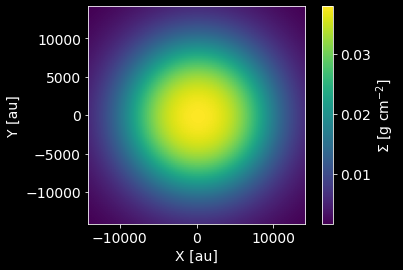

In [251]:
with quantity_support():
    pl.imshow(column, extent=[-rmax.value,rmax.value,-rmax.value,rmax.value])
    cb = pl.colorbar()
    cb.set_label("$\\Sigma$ [g cm$^{-2}$]")
    pl.xlabel("X [au]")
    pl.ylabel("Y [au]")

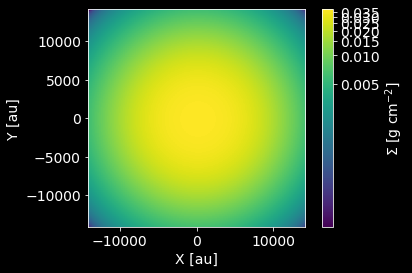

In [252]:
with quantity_support():
    pl.imshow(column, extent=[-rmax.value,rmax.value,-rmax.value,rmax.value],
              norm=simple_norm(column, stretch='log'))
    cb = pl.colorbar()
    cb.set_label("$\\Sigma$ [g cm$^{-2}$]")
    pl.xlabel("X [au]")
    pl.ylabel("Y [au]")

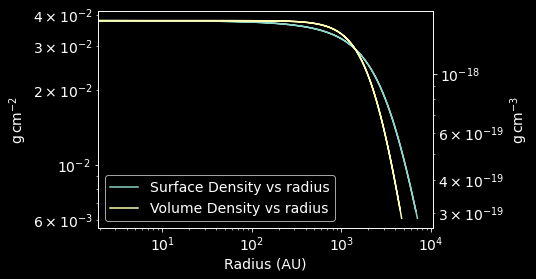

In [253]:
with quantity_support():
    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.loglog(rr_2d[50,50,:], column[50,:], label='Surface Density vs radius', color=colors[0])
    ax2 = ax1.twinx()
    ax2.loglog(rr_3d[50,50,:], density[50,50,:], label='Volume Density vs radius', color=colors[1])
    ax1.set_xlabel("Radius (AU)")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    _=ax2.legend(lines + lines2, labels + labels2, loc='best')

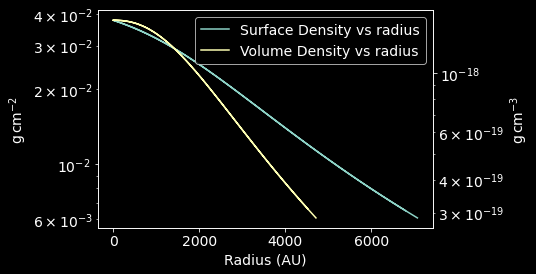

In [254]:
with quantity_support():

    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.semilogy(rr_2d[50,50,:], column[50,:],
                 label='Surface Density vs radius', color=colors[0])
    ax2 = ax1.twinx()
    ax2.semilogy(rr_3d[50,50,:], density[50,50,:],
                 label='Volume Density vs radius', color=colors[1])
    ax1.set_xlabel("Radius (AU)")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    _=ax2.legend(lines + lines2, labels + labels2, loc='best')

Convert to number densities:

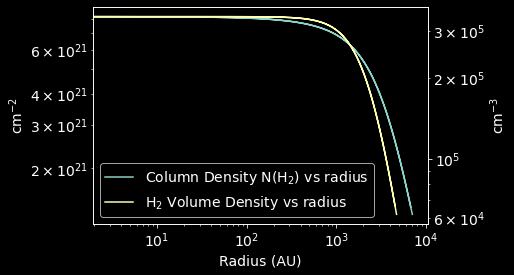

In [255]:
with quantity_support():

    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.loglog(rr_2d[50,50,:], (column[50,:]/(2.8*u.Da)).to(u.cm**-2),
               label='Column Density N(H$_2$) vs radius', color=colors[0])
    ax2 = ax1.twinx()
    ax2.loglog(rr_3d[50,50,:], (density[50,50,:]/(2.8*u.Da)).to(u.cm**-3),
               label='H$_2$ Volume Density vs radius', color=colors[1])
    ax1.set_xlabel("Radius (AU)")


    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    _=ax2.legend(lines + lines2, labels + labels2, loc='best')

# Dust Emissivity



A blackbody has the form:

$$B_\nu = \frac{2 h \nu^3}{c^2} (1-e^{h \nu / k_B T})^{-1}$$

with units $[B_\nu] = \mathrm{Jy}$

The spectral flux density from a blackbody $F_{\nu} = \pi B_{\nu}$ from integrating over a hemisphere (see eqn 2.107-2.110 from https://www.cv.nrao.edu/~sransom/web/Ch2.html).  The flux emitted into a steradian is then $S_\nu = F_\nu / (2 \pi) = B_\nu/2$, since the whole sphere is 4$\pi$ steradians.

Dust has a long-wavelength opacity

$$\kappa_{dust} = \left(\frac{\nu}{\nu_0}\right)^\beta$$

The modified blackbody for dust is given by:

$$S_\nu = \frac{1}{2} \frac{2 h \nu^3}{c^2} \left(1-e^{h \nu / k_B T}\right)^{-1} \left(1-e^{-\kappa_\nu \Sigma}\right)$$

in units of [Jy sr$^{-1}$] where $\kappa_\nu = \kappa_{\nu_0} \left(\frac{\nu}{\nu_0}\right)^{\beta}$ is the dust opacity index with units $[\kappa_\nu] = \frac{\mathrm{cm}^2}{\mathrm{g}}$.  


$\Sigma$ is the surface density in $[\Sigma] = \frac{\mathrm{g}}{\mathrm{cm^2}}$.  


The optical depth $\tau = \kappa_\nu \Sigma$


We can adopt $\kappa_{1 mm} = 0.0136$ cm$^{-2}$ g from [Ossenkopf & Henning 1994](https://ui.adsabs.harvard.edu/abs/1994A%26A...291..943O/abstract).

Note that this is the _opacity per total mass_ - we call it the dust opacity, but the mass is the mass of _all gas and dust_.

We can now calculate the optical depth of our core (at a hypothetical observed wavelength of 1mm):

In [256]:
opacity = 0.0136*u.cm**2*u.g**-1
optical_depth = (column * opacity).decompose()

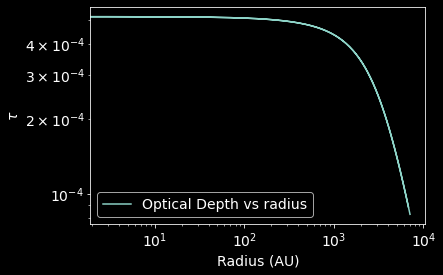

In [257]:
with quantity_support():
    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.loglog(rr_2d[50,50,:], optical_depth[50,:], label='Optical Depth vs radius', color=colors[0])
    ax1.set_xlabel("Radius (AU)")
    ax1.legend(loc='best')
    ax1.set_ylabel("$\\tau$")

# Optical depth -> intensity

This is a very optically thin object.

The modified blackbody approximates, in the $\tau<<1$ regime, to:
\begin{eqnarray}
S_\nu & = & \frac{1}{2} \frac{2 h \nu^3}{c^2} \left(e^{h \nu / k_B T}-1\right)^{-1} \kappa_\nu \Sigma \\
      & = & \frac{1}{2} \frac{2 h \nu^3}{c^2} \left(e^{h \nu / k_B T}-1\right)^{-1} \tau
\end{eqnarray}

(recall the Taylor series: $e^{-x} \approx 1-x+\mathcal{O}(x^2)$)


We can calculate this:

In [258]:
nu = (1*u.mm).to(u.GHz, u.spectral())
fnu = (constants.h * nu**3 / constants.c**2 *
       (np.exp(constants.h * nu / (constants.k_B * T))-1)**-1 * 
       optical_depth).to(u.Jy) / u.sr

The _brightness temperature_ is commonly used to express the surface brightness of an object.  It is given by

$$F_\nu \equiv \frac{2 k_B T_B \nu^2}{c^2} $$

i.e., it is defined by the Rayleigh-Jeans approximation.

Therefore
$$ T_B = \frac{c^2 F_\nu}{2 k_B \nu^2}$$

In [259]:
tb = (fnu * u.sr * constants.c**2 / (2*constants.k_B * nu**2)).to(u.K)

In [260]:
# astropy version (same as above)
tb2 = fnu.to(u.K, u.brightness_temperature(nu))

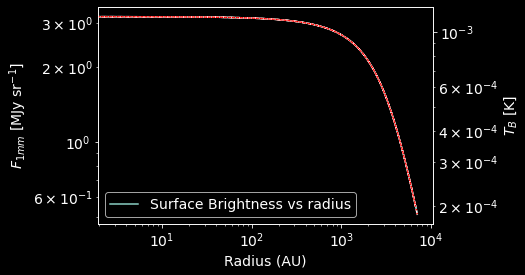

In [264]:
with quantity_support():
    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.subplot()
    ax1.loglog(rr_2d[50,50,:], fnu[50,:].to(u.MJy/u.sr), label='Surface Brightness vs radius', color=colors[0])
    ax2 = ax1.twinx()
    ax2.loglog(rr_2d[50,50,:], tb[50,:], label='Brightness Temperature vs radius', color='w', linestyle='--')
    ax2.loglog(rr_2d[50,50,:], tb2[50,:], label='Brightness Temperature vs radius', color='r', linestyle=':')
    ax1.set_xlabel("Radius (AU)")
    ax1.legend(loc='best')
    ax1.set_ylabel("$F_{1 mm}$ [MJy sr$^{-1}$]")
    ax2.set_ylabel("$T_B$ [K]")

What would we observe if we measured the whole object with a telescope whose resolution is ~$r_0$?

This is a 'beam matched' observation: we barely resolve the object.

We simply average the brightness over the area and multiply by the area to obtain the total flux.

Let's say we're observing B68, which has $r_{FWHM}\sim150"$.  

In [265]:
FWHM_to_sigma = np.sqrt(8*np.log(2))
total_fluxdensity = (fnu[rr_2d[0,:,:] < r0].mean() * (150*u.arcsec / FWHM_to_sigma)**2 * np.pi).to(u.Jy)
total_fluxdensity

<Quantity 0.87619443 Jy>

From [Bianchi+ 2003](https://www.aanda.org/articles/aa/pdf/2003/09/aael211.pdf):
"The final SIMBA image of Barnard 68 has a residual noise of 5.5 mJy beam$^{−1}$ (1-σ), equivalent to 0.36 MJy sr$^{−1}$ for the SIMBA resolution. The integrated flux is $F_{1.2 mm} = 0.7 \pm 0.2$ Jy."

We can compare their surface brightness sensitivity to our predicted flux

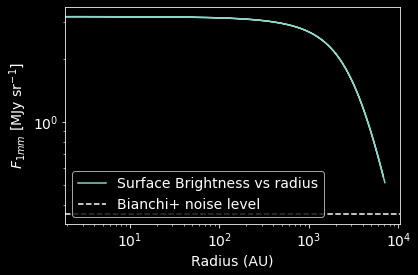

In [266]:
with quantity_support():
    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.subplot()
    ax1.loglog(rr_2d[50,50,:], fnu[50,:].to(u.MJy/u.sr), label='Surface Brightness vs radius', color=colors[0])
    ax1.axhline(0.36*u.MJy/u.sr, linestyle='--', label='Bianchi+ noise level')
    ax1.set_xlabel("Radius (AU)")
    ax1.legend(loc='lower left')
    ax1.set_ylabel("$F_{1 mm}$ [MJy sr$^{-1}$]")
    ax2.set_ylabel("$T_B$ [K]")

This is the same flux we would observe if B68 were 10x further (D=1.2 kpc) and therefore smaller (15")